In [424]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import Normal, Categorical
from tqdm.auto import trange
import einops
from gfn_attractors.misc import utils
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
from collections.abc import Iterable
import string

import pandas as pd
from plotnine import *


In [2]:
device = 1
torch.tensor(0., device=device)

tensor(0., device='cuda:1')

In [35]:
def is_iterable(obj, allow_str=False):
    if isinstance(obj, np.ndarray) or isinstance(obj, torch.Tensor):
        return len(obj.shape) > 0
    if allow_str:
        return isinstance(obj, Iterable)
    else:
        return isinstance(obj, Iterable) and not isinstance(obj, str)

def extract_args(args):
    """
    Use when *args is used as a function parameter.
    Allows both an iterable and a sequence of parameters to be passed in.
    For example, if f([1, 2, 3]) and f(1, 2, 3) will be valid inputs to the following function
        def f(*args):
            args = extract_args(args)
            ...
    @param args:
    @return:
    """
    if len(args) == 1 and is_iterable(args[0]):
        return args[0]
    return args

def prepend_shape(tensor, *shape):
    shape = extract_args(shape)
    dims = {a: i for a, i in zip(string.ascii_lowercase, shape)}
    letters = ' '.join(string.ascii_lowercase[:len(shape)])
    return einops.repeat(tensor, f'... -> {letters} ...', **dims)

def save_model(model, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), path)


def load_model(model, path, map_location='cpu'):
    model.load_state_dict(torch.load(path, map_location=map_location))

# Data

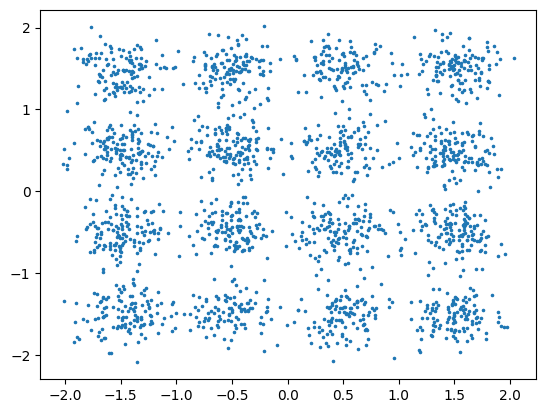

In [3]:
n = 2000
sd = .2
length1 = 1
length2 = .5
means1 = length1 * torch.tensor([[1., 1], [1, -1], [-1, 1], [-1, -1]], device=device)
means2 = length2 * torch.tensor([[1., 1], [1, -1], [-1, 1], [-1, -1]], device=device)

idx = torch.randint(0, 4, (n, 2), device=device)
means = means1[idx[:,0]] + means2[idx[:,1]]
data = Normal(means, sd * torch.ones_like(means)).sample()
plt.scatter(*data.cpu().numpy().T, s=2.5)

# Model

The model uses true $\sigma^2_x$ = 1 (SD in a cluster). $\sigma^2_z$ is learned, but uses the same one for all $z_i$ for both forwards and backwards.

Assumes uniform prior over $P(w_1, w_2)$.

In [5]:
class Model(nn.Module):
    
    def __init__(self, k, sd_x,dim_z=8, dim_h=96):
        super().__init__()
        self.k = k
        self.sd_x = sd_x
        self.dim_h = dim_h
        self.dim_z = dim_z
        self.log_sigma_z = nn.Parameter(torch.tensor(0.))
        
        # Forward policies: w -> z -> x
        self.w_to_z = nn.Sequential(
            nn.Linear(2*k, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_z)
        )
        self.z_to_x = nn.Sequential(
            nn.Linear(dim_z, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, 2)
        ) 
        
        # Backward policies: x -> z -> w
        self.x_to_z = nn.Sequential(
            nn.Linear(2, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_z)
        )
        self.z_to_w = nn.Sequential(
            nn.Linear(dim_z, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, 2*k)
        )
        
    @property
    def sigma_z(self):
        return self.log_sigma_z.exp()
    
    def sample_z_x(self, x, n=1, z=None):
        mu = self.x_to_z(x)
        sigma = self.sigma_z
        dist = Normal(mu, sigma)
        if z is None:
            z = dist.sample((n, ))
        logp = dist.log_prob(z).sum(-1)
        return z, logp
        
    def sample_w_z(self, z, p_explore=0):
        ws = []
        logpb = 0
        for logp in self.z_to_w(z).split(self.k, dim=-1):
            logp = logp.log_softmax(-1)
            policy = logp.exp() * (1-p_explore) + p_explore/self.k
            w = Categorical(policy).sample()
            logp = logp.gather(2, w.unsqueeze(-1)).squeeze(-1)
            ws.append(w.squeeze(-1))
            logpb += logp
        w = torch.stack(ws, dim=-1)
        return w, logpb
    
    def sample_z_w(self, w, n=1, z=None):
        w = F.one_hot(w).flatten(-2, -1).float()
        mu = self.w_to_z(w)
        sigma = self.sigma_z
        dist = Normal(mu, sigma)
        if z is None:
            z = dist.sample((n, ))
        logp = dist.log_prob(z).sum(-1)
        return z.squeeze(0), logp.squeeze(0)
    
    def sample_x_z(self, z, x=None):
        mu = self.z_to_x(z)
        
        sigma = self.sd_x * torch.ones_like(mu)
        dist = Normal(mu, sigma)
        if x is None:
            x = dist.sample()
        logp = dist.log_prob(x).sum(-1)
        return x, logp
        
    def sample_latents(self, x, n=1, p_explore=0):
        z, logpb_z = self.sample_z_x(x, n=n)
        w, logpb_w = self.sample_w_z(z, p_explore)
        logpb = logpb_z + logpb_w
        return z.squeeze(0), w.squeeze(0), logpb.squeeze(0)

In [6]:
model = Model(k=4, dim_z=2, sd_x=sd).to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

  0%|          | 0/5001 [00:00<?, ?it/s]

update: 0 | mle: 34.806 | tbc: 79.864 | sigma_z: 0.999


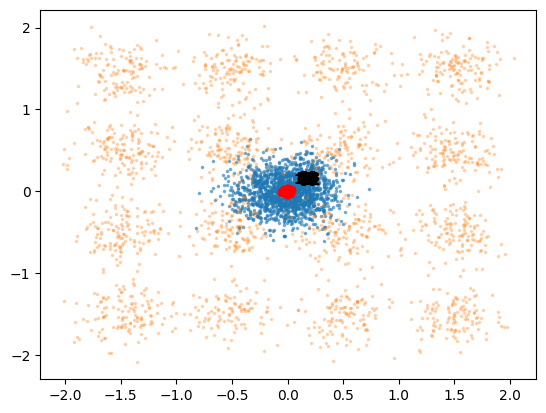

update: 500 | mle: 5.551 | tbc: 9.583 | sigma_z: 0.746


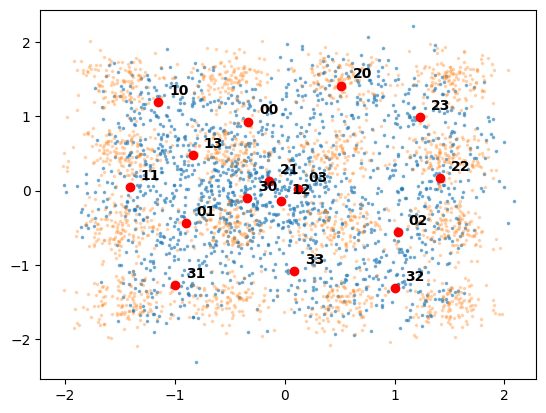

update: 1000 | mle: 4.671 | tbc: 9.378 | sigma_z: 0.551


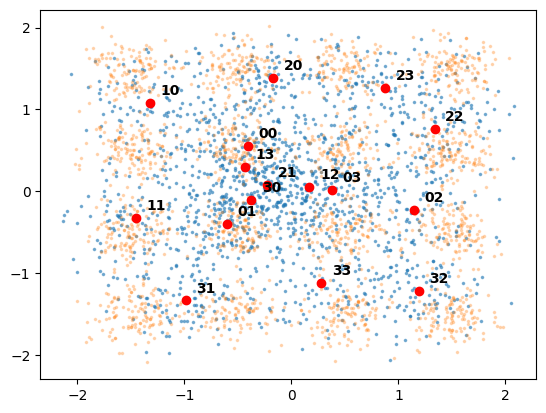

update: 1500 | mle: 4.281 | tbc: 9.496 | sigma_z: 0.383


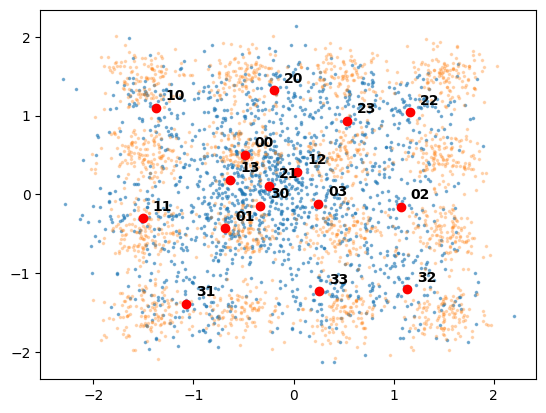

update: 2000 | mle: 3.579 | tbc: 11.314 | sigma_z: 0.268


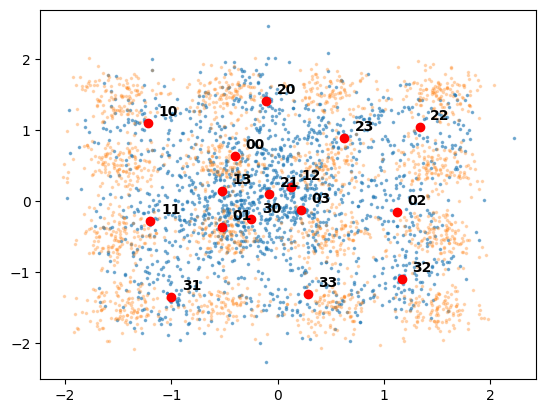

update: 2500 | mle: 3.233 | tbc: 13.81 | sigma_z: 0.185


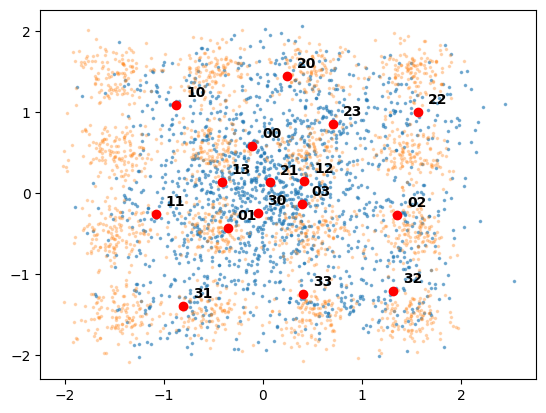

update: 3000 | mle: 2.864 | tbc: 13.7 | sigma_z: 0.134


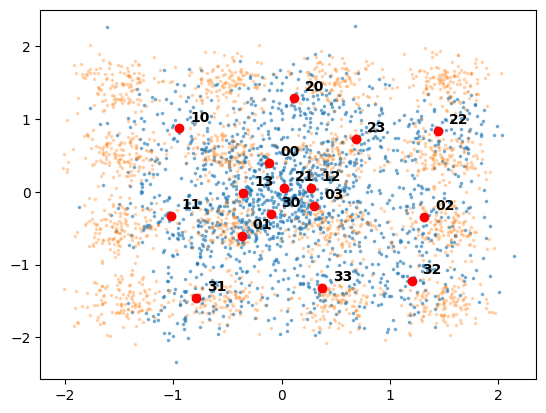

update: 3500 | mle: 2.358 | tbc: 12.716 | sigma_z: 0.097


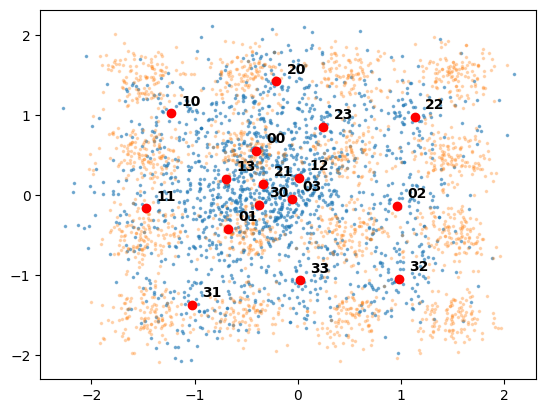

update: 4000 | mle: 6.776 | tbc: 56.055 | sigma_z: 0.073


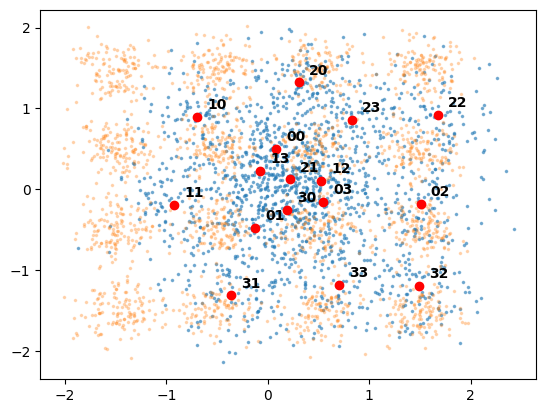

update: 4500 | mle: 1.005 | tbc: 15.693 | sigma_z: 0.056


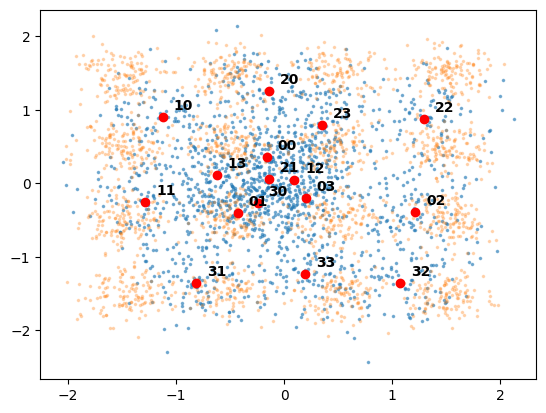

update: 5000 | mle: 1.907 | tbc: 25.557 | sigma_z: 0.047


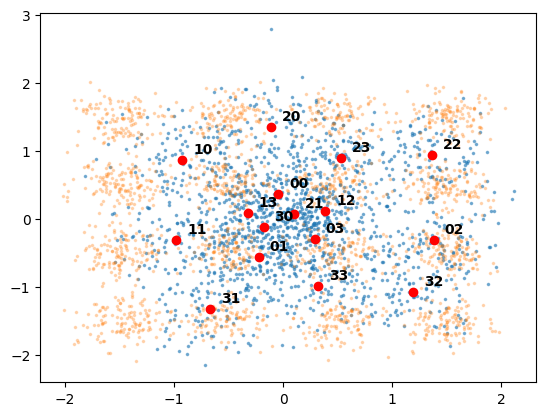

In [7]:
p_explore = .1
d = einops.repeat(data, 'n x -> 2 n x')
for update in trange(5001):
    # M-step
    with torch.no_grad():
        z, w, logpb = model.sample_latents(data, p_explore=p_explore)
    z, logpf_z = model.sample_z_w(w, z=z)
    x, logpf_x = model.sample_x_z(z, x=data)
    logpf = logpf_z + logpf_x
    mle_loss = -logpf.mean()
    
    # E-step
    z, w, logpb = model.sample_latents(data, 2, p_explore=p_explore)
    with torch.no_grad():
        z, logpf_z = model.sample_z_w(w, z=z)
        x, logpf_x = model.sample_x_z(z, x=d)
        logpf = logpf_z + logpf_x
    tbc_loss = logpf[0] - logpb[0] - logpf[1] + logpb[1]
    tbc_loss = (tbc_loss**2).mean()

    loss = mle_loss + tbc_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if update%500 == 0:
        utils.kv_print(update=update, mle=mle_loss, tbc=tbc_loss, sigma_z=model.sigma_z)#, sigma=sigma_x.mean((0, 1)))
        w = torch.tensor(list(itertools.product(range(model.k), range(model.k))), device=device)
        with torch.no_grad():
            z, logpf_z = model.sample_z_w(w, n=100)
            x, logpf_x = model.sample_x_z(z)
        plt.scatter(*x.cpu().numpy().T, s=2.5, alpha=.5)
        plt.scatter(*data.cpu().numpy().T, s=2.5, alpha=.25)
        for (w1, w2), (x, y) in zip(w.cpu().numpy(), x.mean(0).cpu().numpy()):
            plt.plot(x, y, 'ro')
            plt.text(x+.1, y+.1, '%d%d' % (w1, w2), fontweight='bold')
        plt.show()

# With LM

In [493]:
class Model(nn.Module):
    
    def __init__(self, sd_x, dim_z=8, vocab_size=4, dim_h=96, nhead=1):
        super().__init__()
        self.sd_x = sd_x
        self.dim_h = dim_h
        self.dim_z = dim_z
        self.log_sigma_z = nn.Parameter(torch.tensor(0.))
        self.vocab_size = vocab_size
        
        self.sos = nn.Parameter(torch.rand(dim_z))
        self.pe = PositionalEncoding(dim_z)
        self.token_embedding = nn.Embedding(vocab_size+1, dim_z)
        self.token_decoder = nn.Linear(dim_z, vocab_size+1)
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_z, nhead=nhead, dim_feedforward=512, batch_first=True)
        self.z_to_w = nn.TransformerDecoder(decoder_layer, num_layers=2)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_z, nhead=nhead, dim_feedforward=512, batch_first=True)
        self.w_to_z = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Forward policies: w -> z -> x
        self.z_to_x = nn.Sequential(
            nn.Linear(dim_z, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, 2)
        ) 
        
        # Backward policies: x -> z -> w
        self.x_to_z = nn.Sequential(
            nn.Linear(2, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_z)
        )
        
    @property
    def sigma_z(self):
        return self.log_sigma_z.exp()
    
    def sample_z_x(self, x, n=1, z=None):
        mu = self.x_to_z(x)
        sigma = self.sigma_z
        dist = Normal(mu, sigma)
        if z is None:
            z = dist.sample((n, ))
        logp = dist.log_prob(z).sum(-1)
        return z.squeeze(0), logp.squeeze(0)
        
    def sample_w_z(self, z, max_length, p_explore=0):
        batch_shape = z.shape[:-1]
        z = z.view(-1, 1, model.dim_z)

        tokens = []
        logpb = torch.zeros(len(z), device=z.device)
        done = torch.zeros(len(z), dtype=bool, device=z.device)
        h_w = einops.repeat(self.sos, 'd -> n 1 d', n=len(z))
        mask = nn.Transformer.generate_square_subsequent_mask(max_length, device=z.device)

        for i in range(max_length):
            h = model.z_to_w(h_w, z, mask[:i+1, :i+1])[:,-1]
            logp_w = self.token_decoder(h).log_softmax(-1)
            policy = (1-p_explore) * logp_w.exp() + p_explore / self.vocab_size
            w = policy.multinomial(1)
            logp_w = logp_w.gather(1, w).squeeze(-1)
            logpb[~done] += logp_w[~done]

            tokens.append(w)
            h_w = torch.cat([h_w, self.token_embedding(w)], dim=1)
            done |= w.squeeze(-1) == self.vocab_size
            if done.all():
                break

        tokens = torch.cat(tokens, dim=1)
        tokens = F.pad(tokens, (0, 1), value=self.vocab_size)
        tokens = tokens.view(*batch_shape, tokens.shape[-1])
        return tokens, logpb.view(batch_shape)
    
    def sample_z_w(self, w, n=1, z=None):
        batch_shape = w.shape[:-1]
        w = w.view(-1, w.shape[-1])
        
        ieos = w.argmax(-1)  # eos is always last token
        h = self.token_embedding(w)
        mask = nn.Transformer.generate_square_subsequent_mask(h.shape[1], device=w.device)
        mu = self.w_to_z(h, mask=mask)
        mu = mu.gather(1, einops.repeat(ieos, 'n -> n 1 z', z=self.dim_z)).squeeze(1)
        mu = mu.view(*batch_shape, self.dim_z)
        
        sigma = self.sigma_z
        dist = Normal(mu, sigma)
        if z is None:
            z = dist.sample((n, ))
            
        logp = dist.log_prob(z).sum(-1)
        return z.squeeze(0), logp.squeeze(0)
    
    def sample_x_z(self, z, x=None):
        mu = self.z_to_x(z)
        
        sigma = self.sd_x * torch.ones_like(mu)
        dist = Normal(mu, sigma)
        if x is None:
            x = dist.sample()
        logp = dist.log_prob(x).sum(-1)
        return x, logp
        
    def sample_latents(self, x, max_length, n=1, p_explore=0):
        z, logpb_z = self.sample_z_x(x, n=n)
        w, logpb_w = self.sample_w_z(z, max_length, p_explore)
        logpb = logpb_z + logpb_w
        return z.squeeze(0), w.squeeze(0), logpb.squeeze(0)

In [494]:
def get_logp_w(w):
    return (1 / (1 + w.argmax(-1))).log()

In [502]:
model = Model(dim_z=8, sd_x=sd, vocab_size=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)
max_length = 3

  0%|          | 0/3001 [00:00<?, ?it/s]

update: 0 | mle: 47.276 | tbc: 52.686 | sigma_z: 1.001


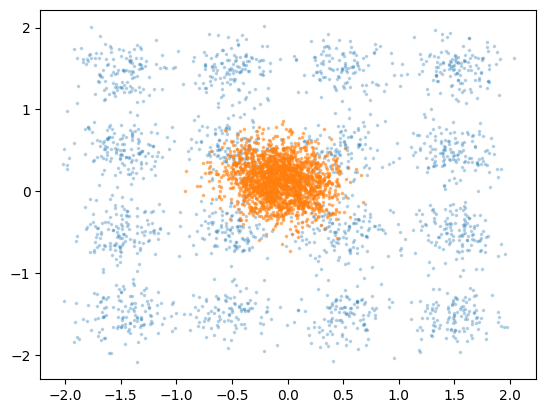

update: 500 | mle: 14.568 | tbc: 31.73 | sigma_z: 0.655


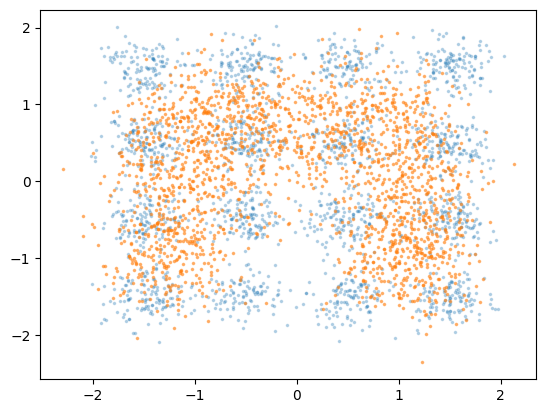

update: 1000 | mle: 10.352 | tbc: 25.902 | sigma_z: 0.446


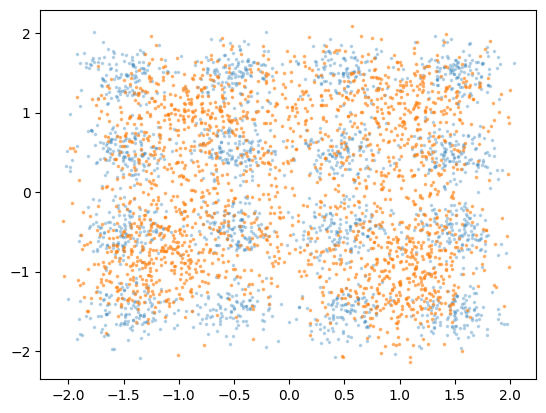

update: 1500 | mle: 7.088 | tbc: 20.74 | sigma_z: 0.316


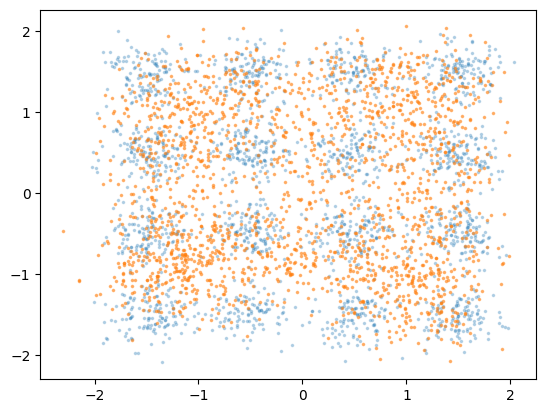

update: 2000 | mle: 4.493 | tbc: 18.051 | sigma_z: 0.223


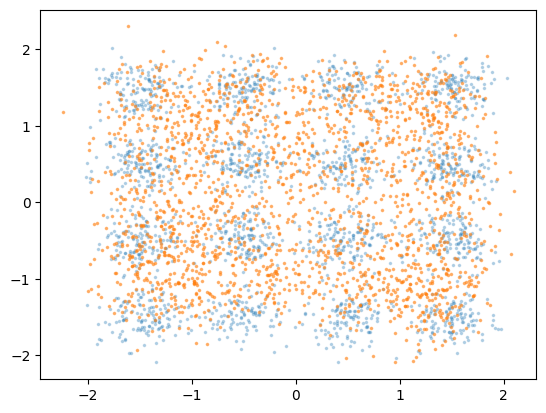

update: 2500 | mle: 1.379 | tbc: 17.086 | sigma_z: 0.163


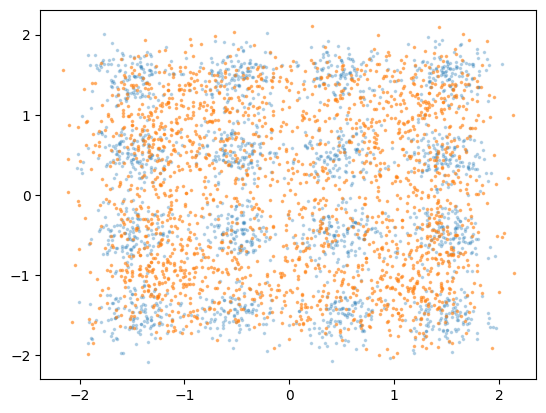

update: 3000 | mle: -1.215 | tbc: 15.767 | sigma_z: 0.119


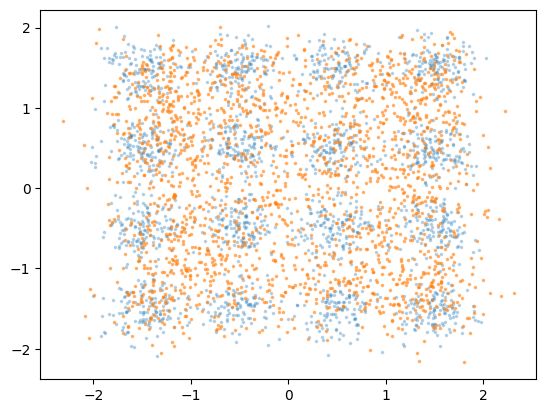

In [503]:
p_explore = .1
d = einops.repeat(data, 'n x -> 2 n x')
for update in trange(3001):
    # M-step
    with torch.no_grad():
        z, w, logpb = model.sample_latents(data, max_length=max_length, p_explore=p_explore)
    z, logpf_z = model.sample_z_w(w, z=z)
    x, logpf_x = model.sample_x_z(z, x=data)
    logpf = get_logp_w(w) + logpf_z + logpf_x
    mle_loss = -logpf.mean()
    
    # E-step
    z, w, logpb = model.sample_latents(data, max_length=max_length, n=2, p_explore=p_explore)
    with torch.no_grad():
        z, logpf_z = model.sample_z_w(w, z=z)
        x, logpf_x = model.sample_x_z(z, x=d)
        logpf = get_logp_w(w) + logpf_z + logpf_x
    tbc_loss = logpf[0] - logpb[0] - logpf[1] + logpb[1]
    tbc_loss = (tbc_loss**2).mean()

    loss = mle_loss + tbc_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if update%500 == 0:
        utils.kv_print(update=update, mle=mle_loss, tbc=tbc_loss, sigma_z=model.sigma_z)
        with torch.no_grad():
            z, w, logpb = model.sample_latents(data, max_length=max_length)
            z, logpf_z = model.sample_z_w(w)
            x, logpf_x = model.sample_x_z(z)
        plt.scatter(*data.cpu().numpy().T, s=2.5, alpha=.25)
        plt.scatter(*x.cpu().numpy().T, s=2.5, alpha=.5)
        plt.show()

In [504]:
# Sample from prior
ws = []
for i in range(model.vocab_size):
    w = torch.tensor(list(itertools.product(*[range(4)]*i)), device=device)
    w = F.pad(w, (0, 1), value=model.vocab_size)
    w = F.pad(w, (0, 1 + max_length - w.shape[-1]))
    ws.append(w)
w = torch.cat(ws, dim=0)
p_w = get_logp_w(w).exp()
idx = p_w.multinomial(n, replacement=True)
w = w[idx].int()

with torch.no_grad():
    z, logpf_z = model.sample_z_w(w)
    x, logpf_x = model.sample_x_z(z)

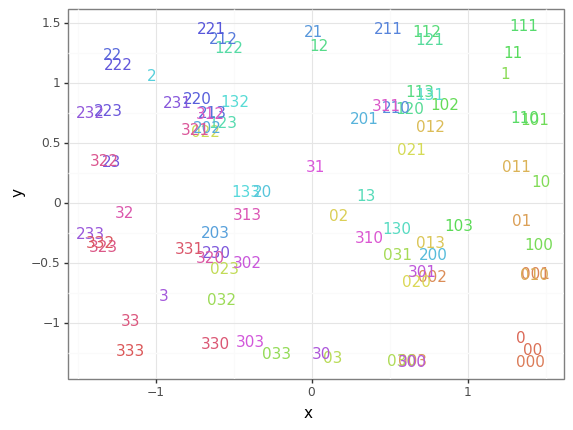

<ggplot: (8736441100391)>

In [505]:
df = pd.DataFrame(x.cpu().numpy(), columns=['x', 'y'])
df['w'] = [''.join([str(c) for c in s]) for s in w.tolist()]
df['p_w'] = get_logp_w(w).exp().cpu().numpy()
df['w_idx'] = idx.cpu().numpy()
df.w = [w[:w.find(str(model.vocab_size))] for w in df.w]
df.to_csv("lm_results.tsv", sep='\t', index=False)

df_avg = df.groupby('w', as_index=False).mean(['x', 'y'])
(ggplot(aes(x='x', y='y', color='w', label='w'), df_avg)
+ geom_text()
+ theme_bw()
+ theme(legend_position='none'))

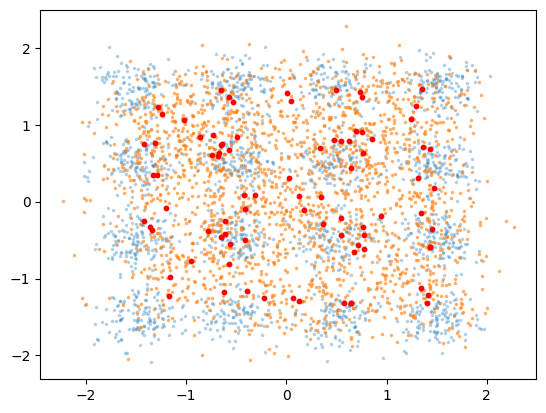

In [506]:
plt.scatter(*data.cpu().numpy().T, s=2.5, alpha=.25)
plt.scatter(*x.cpu().numpy().T, s=2.5, alpha=.5)
plt.scatter(*df_avg[['x', 'y']].values.T, s=10, c='red')